# 007. Investigating a major flooding event: May-June 2013 - Danube in Lower Austria

To get a feel how different variables correlate with each other for floodings, we look at one example for the Danube region.

We specify the point of interest near the city Krems, which is located directly next to the Danube in Lower Austria and was heavily affected by the major flooding event.

enable parent dir package loading

In [1]:
import link_src

In [ ]:
%matplotlib inline
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

from dask.distributed import Client
client = Client(processes=True)
import dask
#dask.config.set(scheduler='processes')
from dask.diagnostics import ProgressBar

In [148]:
from python.aux.ml_flood_config import path_to_data
from python.aux.utils import open_data
from python.aux.plot import Map
from python.aux.utils import calc_stat_moments
from python.aux.utils import spatial_cov

In [4]:
# load dask client
client
# define some vars
data_path = f'{path_to_data}danube/'
print(data_path)

/home/srvx11/lehre/users/a1303583/ipython/ml_flood/data/danube/


In [ ]:
# load data
era5 = open_data(data_path, kw='era5')
glofas = open_data(data_path, kw='glofas_ra')

First of all, we need to specify the lat and lon values for Krems.

In [81]:
lat = 48.403
lon = 15.615
krems = dict(latitude=lat, longitude=lon)

Let us take a look how the river discharge in the GLOFAS Reanalysis developed over time.

In [46]:
start_date = '2013-05-20'
end_date = '2013-07-20'
dis_krems = glofas.sel(time=slice(start_date, end_date)).interp(krems).drop(['latitude', 'longitude'])['dis']
long_term_mean_krems = glofas.interp(krems).drop(['latitude', 'longitude'])['dis'].mean().values
print(dis_krems)

<xarray.DataArray 'dis' (time: 62)>
dask.array<shape=(62,), dtype=float32, chunksize=(62,)>
Coordinates:
  * time     (time) datetime64[ns] 2013-05-20 2013-05-21 ... 2013-07-20
Attributes:
    long_name:  discharge
    units:      m3/s


Text(0.5, 1.0, "GLOFAS river discharge at {'latitude': 48.403, 'longitude': 15.615}")

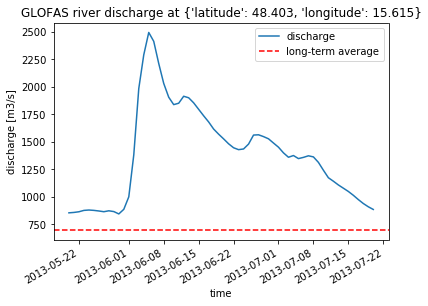

In [47]:
dis_krems.plot(label='discharge')
plt.gca().axhline(long_term_mean_krems, ls='--', color='r', label='long-term average')
plt.legend()
plt.title(f'GLOFAS river discharge at {krems}')

We can see that the event hit Krems at the beginning of June, but the higher levels of discharge lasted for a very long term, as is usual for major flooding events (after a flash flooding event the discharge level would go back to more average levels much quicker.

What is of big interest, is of course the beginning of the event, i.e. the sudden increase (almost trippling) of the river discharge.

Going forward, we want to find to find and distinguish between two factors:
- i. changes in discharge happening locally, where we suppose that mainly precipitation and runoff are the causing factors
- ii. changes in discharge happening from mass influx on some location far away (far away corresponds - in our terms - to the approximate distance the mean flow transports a mass particle during one day: this, of course, varies heavily on the water level, and the location; we assume for the upstream area of Krems ~ 2.2m/s => which translates to about 190 km a day)

This cascades into using a box about 35 grid points across latitude and longitude each to capture all potential 'local' effects.

Hereafter, we distinguish between the two tasks and call the first one 'local model' and the second one 'transport model' (transport as in: effects changing the discharge level happen outside the 'local' region and thus, are 'transported' into the area of interest.).

Now, lets have a look at at spatial correlations for the period in which the increase happened.

In [106]:
start_date_rise = '2013-05-31'
end_date_rise = '2013-06-06'
dis_krems_rise = glofas.sel(time=slice(start_date_rise, end_date_rise)).interp(krems).drop(['latitude', 'longitude'])['dis']

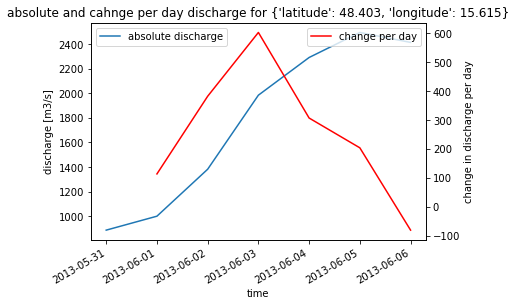

In [123]:
dis_krems_rise.plot(label='absolute discharge')
plt.legend()
plt.gca().twinx()
dis_krems_rise.diff(dim='time').plot(color='r', label='change per day')
plt.ylabel('change in discharge per day')
plt.title(f'absolute and cahnge per day discharge for {krems}')
plt.legend()

Spatial covariances for some variables with local discharge.

In [ ]:
m = Map(figure_kws=dict(figsize=(15,10)))

In [ ]:
from python.aux.utils import spatial_cov_2var

In [124]:
dis_krems_rise_diff = dis_krems_rise.diff(dim='time')
cp_rise = era5['cp'].sel(time=slice(start_date_rise, end_date_rise))[1:]

Text(0.5, 1.0, "spatial covariance between discharge at {'latitude': 48.403, 'longitude': 15.615} and convective precip")

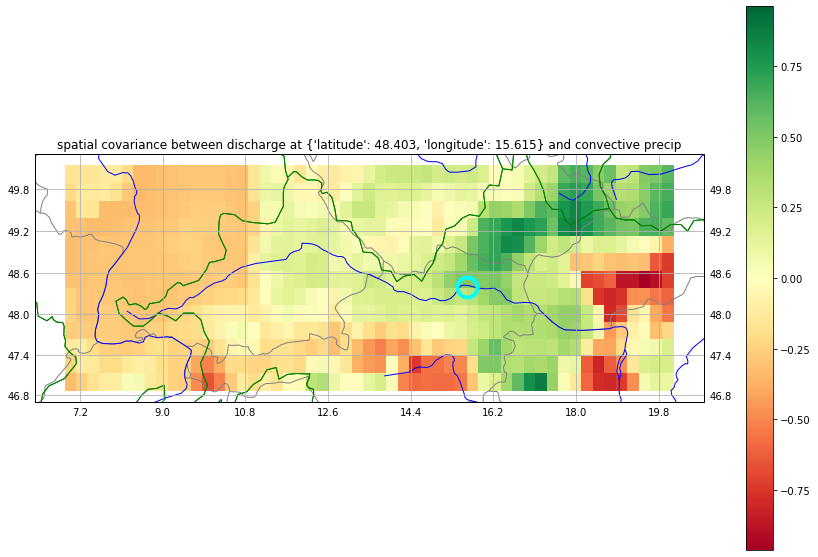

In [132]:
spcov_2 = spatial_cov_2var(dis_krems_rise_diff, cp_rise)
m.plot(spcov_2)
m.plot_point(plt.gca(), lat, lon)
plt.title(f'spatial covariance between discharge at {krems} and convective precip')

In [128]:
lsp_rise = era5['lsp'].sel(time=slice(start_date_rise, end_date_rise))[1:]

Text(0.5, 1.0, "spatial covariance between discharge at {'latitude': 48.403, 'longitude': 15.615} and large-scale precip")

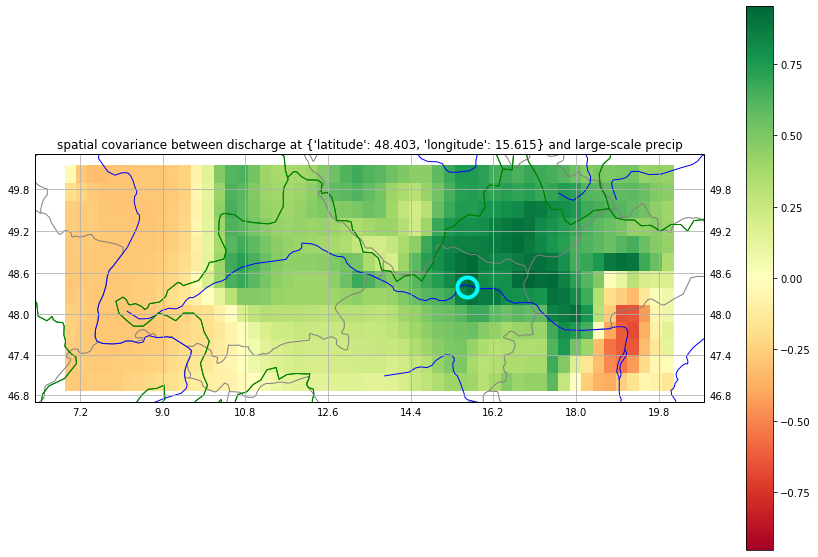

In [133]:
spcov_2 = spatial_cov_2var(dis_krems_rise_diff, lsp_rise)
m.plot(spcov_2)
m.plot_point(plt.gca(), lat, lon)
plt.title(f'spatial covariance between discharge at {krems} and large-scale precip')

In [130]:
ro_rise = era5['ro'].sel(time=slice(start_date_rise, end_date_rise))[1:]

Text(0.5, 1.0, "spatial covariance between discharge at {'latitude': 48.403, 'longitude': 15.615} and runoff")

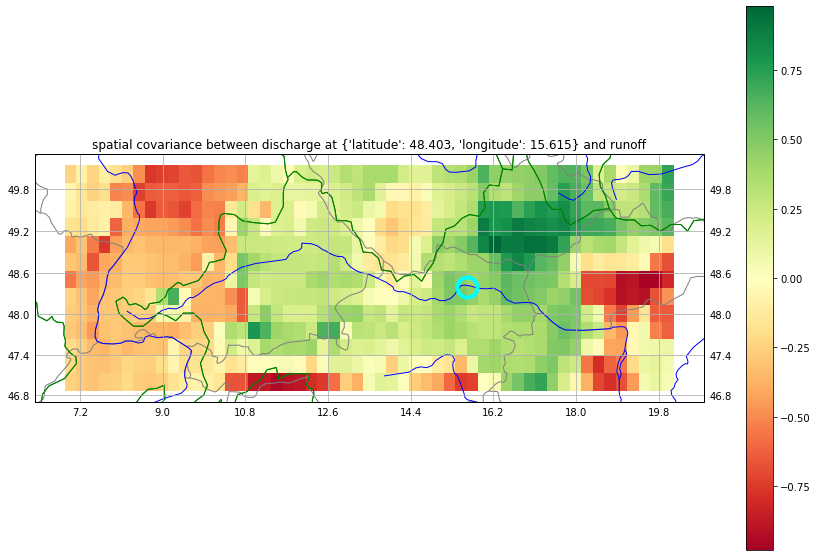

In [134]:
spcov_2 = spatial_cov_2var(dis_krems_rise_diff, ro_rise)
m.plot(spcov_2)
m.plot_point(plt.gca(), lat, lon)
plt.title(f'spatial covariance between discharge at {krems} and runoff')

We can see, that especially the large-scale precipitation features high correlation with the discharge at Krems. The correlation far away is of course unrealistic from a physical point of view, but it indicates that maybe a synoptic event was responsible for the increase (which was indeed the case).

This also highlights the significance to incorporate the whole catchment basin into the prediction for a downstream location. Using all values inside the catchment as features in ML models would technically be possible, but unfeasible reagarding computational ressources.

At the next step, we want to look at the 'local' vicinity around the location of interest.

Note that 1.5 degrees is approximately the already mentioned range incorporated in the 'local model', due to the rivers not flowing in a straight fashion.

In [136]:
local_region = dict(latitude=slice(krems['latitude']+1.5,
                                   krems['latitude']-1.5),
                    longitude=slice(krems['longitude']-1.5,
                                    krems['longitude']+1.5))

In [143]:
start_date = '2013-05-20'
end_date = '2013-07-20'
xds = era5.sel(local_region).sel(time=slice(start_date, end_date))
yda = dis_krems.copy()
print(xds)
print(yda)

<xarray.Dataset>
Dimensions:    (latitude: 12, level: 3, longitude: 12, time: 62)
Coordinates:
  * time       (time) datetime64[ns] 2013-05-20 2013-05-21 ... 2013-07-20
  * latitude   (latitude) float32 49.75 49.5 49.25 49.0 ... 47.5 47.25 47.0
  * longitude  (longitude) float32 14.25 14.5 14.75 15.0 ... 16.5 16.75 17.0
  * level      (level) float64 850.0 700.0 500.0
Data variables:
    cp         (time, latitude, longitude) float32 dask.array<shape=(62, 12, 12), chunksize=(62, 12, 12)>
    tp         (time, latitude, longitude) float32 dask.array<shape=(62, 12, 12), chunksize=(62, 12, 12)>
    lsp        (time, latitude, longitude) float32 dask.array<shape=(62, 12, 12), chunksize=(62, 12, 12)>
    z          (time, level, latitude, longitude) float32 dask.array<shape=(62, 3, 12, 12), chunksize=(62, 3, 12, 12)>
    t          (time, level, latitude, longitude) float32 dask.array<shape=(62, 3, 12, 12), chunksize=(62, 3, 12, 12)>
    q          (time, level, latitude, longitude) float32

In [147]:
yda_change = yda.diff(dim='time')
yda_change.name = 'dis_change'
print(yda_change)

<xarray.DataArray 'dis_change' (time: 61)>
dask.array<shape=(61,), dtype=float32, chunksize=(61,)>
Coordinates:
  * time     (time) datetime64[ns] 2013-05-21 2013-05-22 ... 2013-07-20


In [151]:
sm_era5 = calc_stat_moments(xds, dim_aggregator='spatial')
print(sm_era5)

<xarray.Dataset>
Dimensions:       (level: 3, stat_moments: 3, time: 62)
Coordinates:
  * time          (time) datetime64[ns] 2013-05-20 2013-05-21 ... 2013-07-20
  * level         (level) float64 850.0 700.0 500.0
  * stat_moments  (stat_moments) <U4 'mean' 'std' 'vc'
Data variables:
    cp            (stat_moments, time) float32 dask.array<shape=(3, 62), chunksize=(1, 62)>
    tp            (stat_moments, time) float32 dask.array<shape=(3, 62), chunksize=(1, 62)>
    lsp           (stat_moments, time) float32 dask.array<shape=(3, 62), chunksize=(1, 62)>
    z             (stat_moments, time, level) float32 dask.array<shape=(3, 62, 3), chunksize=(1, 62, 3)>
    t             (stat_moments, time, level) float32 dask.array<shape=(3, 62, 3), chunksize=(1, 62, 3)>
    q             (stat_moments, time, level) float32 dask.array<shape=(3, 62, 3), chunksize=(1, 62, 3)>
    ro            (stat_moments, time) float32 dask.array<shape=(3, 62), chunksize=(1, 62)>
    swvl1         (stat_moments

Plot coefficient of variation for the grid box around krems and compare the time development to absolute and changes in discharge values.

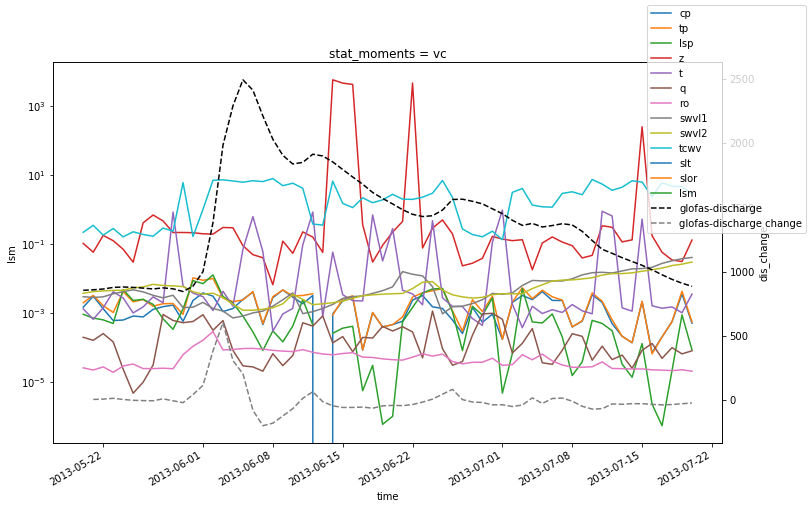

In [190]:
fig, ax = plt.subplots(figsize=(12,7))
for var in sm_era5.variables:
    if not var in ['time', 'level', 'stat_moments']:
        da_iter = sm_era5[var].sel(stat_moments='vc')
        try:
            da_iter.mean(dim='level').plot(ax=ax, label=var)
        except:
            da_iter.plot(ax=ax, label=var)

plt.yscale('log')
ax2 = ax.twinx()
yda.plot(ax=ax2, ls='--', color='k', label='glofas-discharge')
yda_change.plot(ax=ax2, ls='--', color='grey', label='glofas-discharge change')
fig.legend()

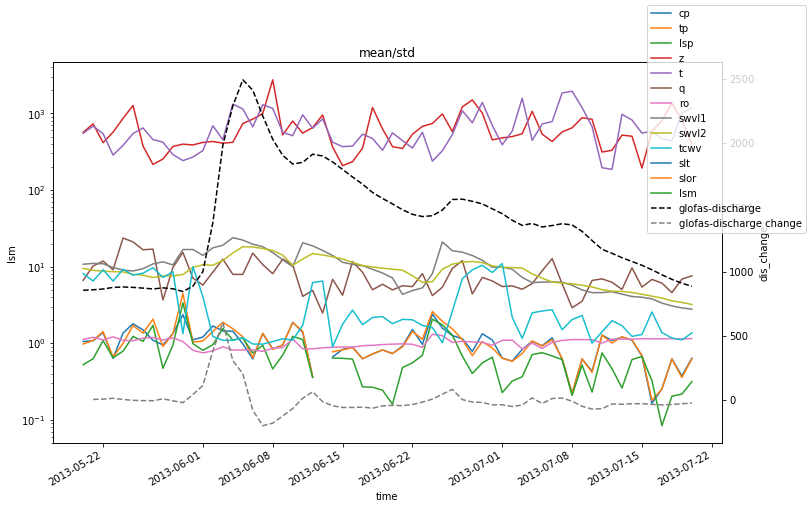

In [189]:
fig, ax = plt.subplots(figsize=(12,7))
for var in sm_era5.variables:
    if not var in ['time', 'level', 'stat_moments']:
        da_iter = sm_era5[var].sel(stat_moments='mean')/sm_era5[var].sel(stat_moments='std')
        try:
            da_iter.mean(dim='level').plot(ax=ax, label=var)
        except:
            da_iter.plot(ax=ax, label=var)

plt.yscale('log')
ax2 = ax.twinx()
yda.plot(ax=ax2, ls='--', color='k', label='glofas-discharge')
yda_change.plot(ax=ax2, ls='--', color='grey', label='glofas-discharge change')
plt.title('mean/std')

fig.legend()